In [14]:
from pylab import *
ion()

from numpy import *
import numpy as np
eig = linalg.eig
eigvals = linalg.eigvals
svd = linalg.svd
inv = linalg.inv
pinv = linalg.pinv
import time

import numba
from numba import njit

import scipy
from scipy import ndimage
gfilt =ndimage.gaussian_filter

resultsfile = "dataHan256/"
mfact = 2       #specifies size of the phantom image. The phantom image size will be (512/mfact)^2
cutoffparm = 4.0  # parameter for the sqrt-hanning filter

#load in a test image
imagenumber = 3  # selection range is 0 through 9
material = "Adipose"  # options are "Adipose", "Fibroglandular" and "Calcification"
phantom1 =load("Phantom_"+material+".npy")[imagenumber]
material = "Fibroglandular" 
phantom2 =load("Phantom_"+material+".npy")[imagenumber]
material = "Calcification" 
phantom3 =load("Phantom_"+material+".npy")[imagenumber]

testimage = (0.5*phantom1 + 1.0*phantom2 + 2.0*phantom3).astype("float64")   #Build our testimage
testimage = testimage[::mfact,::mfact]*1.

# searched optimal parameter settings for different phantom sizes
# 128, alpha=1.95 , beta = 10
# 256, alpha=1.9  , beta = 10
# 512, alpha=1.7  , beta = 5

addnoise = 0
nph = 1.e6
nuxfact = 0.5 #combination factor for x-gradient with projection matrix
nuyfact = 0.5 #combination factor for y-gradient with projection matrix
l1f = 1.0 #don't change this parameter yet
eps = 0.001 # data error constraint in terms of RMSE
larc = 1.0 #1.0 (if limited angular range)  or 0.0 (full 360 scan)
alpha = 1.75  #combination strength of x- and y- gradients
beta = 5.0
rho = 1.75 #over-relaxation parameter for He-Yuan predictor corrector

stepbalance = 100.0 # step-size ratio for CP, needs to be tuned 

# === Two-channel fidelity split & low-frequency acceleration ===
two_channel = True          # enable low+high fidelity channels
cutoffparm_lo = 8.0         # low-pass window is narrower (larger -> narrower passband)
eps_hi = eps                # high-pass constraint (same as eps to start)
eps_lo = 1.25*eps           # slightly looser low-pass constraint
sigma_lo_scale = 4.0        # larger dual step for low-frequency channel


In [15]:
#reduce phantom size
phimage = testimage*1.
testimage = phimage*0.
bpimage = testimage*0.

#image parameters
ximageside = 10.0   #cm
yimageside = 10.0   #cm
nx = int(512/mfact)
ny = int(512/mfact)
npix = nx*ny
dx = ximageside/nx
dy = yimageside/ny
xar=arange(-ximageside/2. + dx/2 , ximageside/2., dx)[:,newaxis]*ones([ny])
yar=ones([nx,ny])*arange(-yimageside/2. + dy/2 , yimageside/2., dy)
rar=sqrt(xar**2 + yar**2)
mask = phimage*0.
mask[rar<=ximageside/2.]=1.
#mask.fill(1.)

# sinogram parameters. Note that there are multiple names for some
# of the parameters. This is due to legacy code.
radius = 50.0    #cm
source_to_detector = 100.0   #cm
srad = radius
sd = source_to_detector
slen = (50./180.)*pi     #angular range of the scan
slen0 = -slen/2.0
ns0 = 25
nu0 = 1024
nviews = ns0   
nbins = nu0
nrays = nbins*nviews
epssc = eps*sqrt(nrays)


# The linear detector length is computed in the projection function so that it is
# the exact size needed to capture the projection of the largest inscribed circle in
# the image array.
fanangle2 = arcsin((ximageside/2.)/radius)  # This only works for ximageside = yimageside
detectorlength = 2.*tan(fanangle2)*source_to_detector
u0 = -detectorlength/2.

du = detectorlength/nbins
ds = slen/(nviews-larc)
dup = du*radius/source_to_detector  #detector bin spacing at iso-center

In [16]:
sinogram=zeros([nviews,nbins])

In [17]:
#@njit(cache=True) # If computing projection multiple times use: @njit(cache=True)
@njit
###############
def circularFanbeamProjection(image,sinogram, 
                              nx = nx, ny = ny, ximageside = ximageside, yimageside = yimageside,
                              radius = srad, source_to_detector = sd, detectorlength = detectorlength,
                              nviews = ns0, slen = slen, slen0 = slen0, nbins = nu0):


   dx = ximageside/nx
   dy = yimageside/ny
   x0 = -ximageside/2.
   y0 = -yimageside/2.

   #compute length of detector so that it views the inscribed FOV of the image array
   u0 = -detectorlength/2.

   du = detectorlength/nbins
   ds = slen/(nviews-larc)

   for sindex in range(nviews):
#      print("Doing view number: ",sindex)   #UNCOMMENT if you want to see view progress
      s = sindex*ds+slen0
# Location of the source
      xsource=radius*cos(s)
      ysource=radius*sin(s)

# detector center
      xDetCenter=(radius - source_to_detector)*cos(s)
      yDetCenter=(radius - source_to_detector)*sin(s)

# unit vector in the direction of the detector line
      eux = -sin(s)
      euy =  cos(s)

# Unit vector in the direction perpendicular to the detector line
      ewx = cos(s)
      ewy = sin(s)

      for uindex in range(nbins):

         u = u0+(uindex+0.5)*du
         xbin = xDetCenter + eux*u
         ybin = yDetCenter + euy*u

         xl=x0
         yl=y0

         xdiff=xbin-xsource
         ydiff=ybin-ysource
         xad=abs(xdiff)*dy
         yad=abs(ydiff)*dx

         if (xad>yad):   # loop through x-layers of image if xad>yad. This ensures ray hits only one or two pixels per layer
            slope=ydiff/xdiff
            travPixlen=dx*sqrt(1.0+slope*slope)
            yIntOld=ysource+slope*(xl-xsource)
            iyOld=int(floor((yIntOld-y0)/dy))
            raysum=0.
            for ix in range(nx):
               x=xl+dx*(ix + 1.0)
               yIntercept=ysource+slope*(x-xsource)
               iy=int(floor((yIntercept-y0)/dy))
               if iy == iyOld: # if true, ray stays in the same pixel for this x-layer
                  if ((iy >= 0) and (iy < ny)):
                     raysum=raysum+travPixlen*image[ix,iy]
               else:    # else case is if ray hits two pixels for this x-layer
                  yMid=dy*(iy if iy > iyOld else iyOld)+yl
                  ydist1=abs(yMid-yIntOld)
                  ydist2=abs(yIntercept-yMid)
                  frac1=ydist1/(ydist1+ydist2)
                  frac2=1.0-frac1
                  if ((iyOld >= 0) and (iyOld < ny)):
                     raysum = raysum+frac1*travPixlen*image[ix,iyOld]
                  if ((iy>=0) and (iy<ny)):
                     raysum=raysum+frac2*travPixlen*image[ix,iy]
               iyOld=iy
               yIntOld=yIntercept
         else: # loop through y-layers of image if xad<=yad
            slopeinv=xdiff/ydiff
            travPixlen=dy*sqrt(1.0+slopeinv*slopeinv)
            xIntOld=xsource+slopeinv*(yl-ysource)
            ixOld=int(floor((xIntOld-x0)/dx))
            raysum=0.
            for iy in range(ny):
               y=yl+dy*(iy + 1.0)
               xIntercept=xsource+slopeinv*(y-ysource)
               ix=int(floor((xIntercept-x0)/dx))
               if (ix == ixOld): # if true, ray stays in the same pixel for this y-layer
                  if ((ix >= 0) and (ix < nx)):
                     raysum=raysum+travPixlen*image[ix,iy]
               else:  # else case is if ray hits two pixels for this y-layer
                  xMid=dx*(ix if ix > ixOld else ixOld)+xl
                  xdist1=abs(xMid-xIntOld)
                  xdist2=abs(xIntercept-xMid)
                  frac1=xdist1/(xdist1+xdist2)
                  frac2=1.0-frac1
                  if ((ixOld >= 0) and (ixOld < nx)) :
                     raysum=raysum+frac1*travPixlen*image[ixOld,iy]
                  if ((ix>=0) and (ix<nx)) :
                     raysum=raysum+frac2*travPixlen*image[ix,iy]
               ixOld=ix
               xIntOld=xIntercept
         sinogram[sindex,uindex]=raysum
         

In [18]:
@njit(cache=True) # If computing projection multiple times use: @njit(cache=True)
def circularFanbeamBackProjection(sinogram, image,
                              nx = nx, ny = ny, ximageside = ximageside, yimageside = yimageside,
                              radius = srad, source_to_detector = sd, detectorlength  = detectorlength,
                              nviews = ns0, slen = slen,slen0=slen0, nbins = nu0):

   image.fill(0.)

   dx = ximageside/nx
   dy = yimageside/ny
   x0 = -ximageside/2.
   y0 = -yimageside/2.

   u0 = -detectorlength/2.

   du = detectorlength/nbins
   ds = slen/(nviews - larc)

   for sindex in range(nviews):
#      print("Doing view number: ",sindex)   #UNCOMMENT if you want to see view progress
      s = sindex*ds + slen0
# Location of the source
      xsource=radius*cos(s)
      ysource=radius*sin(s)

# detector center
      xDetCenter=(radius - source_to_detector)*cos(s)
      yDetCenter=(radius - source_to_detector)*sin(s)

# unit vector in the direction of the detector line
      eux = -sin(s)
      euy =  cos(s)

# Unit vector in the direction perpendicular to the detector line
      ewx = cos(s)
      ewy = sin(s)

      for uindex in range(nbins):

         sinoval = sinogram[sindex,uindex]
         u = u0+(uindex+0.5)*du
         xbin = xDetCenter + eux*u
         ybin = yDetCenter + euy*u

         xl=x0
         yl=y0

         xdiff=xbin-xsource
         ydiff=ybin-ysource
         xad=abs(xdiff)*dy
         yad=abs(ydiff)*dx

         if (xad>yad):   # loop through x-layers of image if xad>yad. This ensures ray hits only one or two pixels per layer
            slope=ydiff/xdiff
            travPixlen=dx*sqrt(1.0+slope*slope)
            yIntOld=ysource + slope*(xl-xsource)
            iyOld=int(floor((yIntOld-y0)/dy))
            for ix in range(nx):
               x=xl+dx*(ix + 1.0)
               yIntercept=ysource+slope*(x-xsource)
               iy=int(floor((yIntercept-y0)/dy))
               if iy == iyOld: # if true, ray stays in the same pixel for this x-layer
                  if ((iy >= 0) and (iy < ny)):
                     image[ix,iy] =image[ix,iy]+sinoval*travPixlen
               else:    # else case is if ray hits two pixels for this x-layer
                  yMid=dy*(iy if iy > iyOld else iyOld)+yl
                  ydist1=abs(yMid-yIntOld)
                  ydist2=abs(yIntercept-yMid)
                  frac1=ydist1/(ydist1+ydist2)
                  frac2=1.0-frac1
                  if ((iyOld >= 0) and (iyOld < ny)):
                     image[ix,iyOld] =image[ix,iyOld]+frac1*sinoval*travPixlen
                  if ((iy>=0) and (iy<ny)):
                     image[ix,iy] =image[ix,iy]+frac2*sinoval*travPixlen
               iyOld=iy
               yIntOld=yIntercept
         else: # loop through y-layers of image if xad<=yad
            slopeinv=xdiff/ydiff
            travPixlen=dy*sqrt(1.0+slopeinv*slopeinv)
            xIntOld=xsource+slopeinv*(yl-ysource)
            ixOld=int(floor((xIntOld-x0)/dx))
            for iy in range(ny):
               y=yl+dy*(iy + 1.0)
               xIntercept=xsource+slopeinv*(y-ysource)
               ix=int(floor((xIntercept-x0)/dx))
               if (ix == ixOld): # if true, ray stays in the same pixel for this y-layer
                  if ((ix >= 0) and (ix < nx)):
                     image[ix,iy] =image[ix,iy]+sinoval*travPixlen
               else:  # else case is if ray hits two pixels for this y-layer
                  xMid=dx*(ix if ix > ixOld else ixOld)+xl
                  xdist1=abs(xMid-xIntOld)
                  xdist2=abs(xIntercept-xMid)
                  frac1=xdist1/(xdist1+xdist2)
                  frac2=1.0-frac1
                  if ((ixOld >= 0) and (ixOld < nx)) :
                     image[ixOld,iy] =image[ixOld,iy]+frac1*sinoval*travPixlen
                  if ((ix>=0) and (ix<nx)) :
                     image[ix,iy] =image[ix,iy]+frac2*sinoval*travPixlen
               ixOld=ix
               xIntOld=xIntercept

In [19]:
@njit
###############
def circularFanbeamPDBackProjection(sinogram,image, fov_radius = ximageside/1.,
       nx = nx, ny = ny, ximageside = ximageside, yimageside = yimageside,
       radius = radius, source_to_detector = source_to_detector,
       nviews = nviews, slen = slen, slen0 = slen0, nbins = nbins, detectorlength = detectorlength):
# This implementation is for weighted pixel-driven back-projection needed for fan-beam FBP

   dx = ximageside/nx
   dy = yimageside/ny
   x0 = -ximageside/2.
   y0 = -yimageside/2.

   u0 = -detectorlength/2.

   du = detectorlength/nbins
   ds = slen/(nviews -larc)

   for sindex in range(nviews):
#      print("Doing view number: ",sindex)   #UNCOMMENT if you want to see view progress
      s = sindex*ds + slen0
# Location of the source
      xsource=radius*cos(s)
      ysource=radius*sin(s)

# detector center
      xDetCenter=(radius - source_to_detector)*cos(s)
      yDetCenter=(radius - source_to_detector)*sin(s)

# unit vector in the direction of the detector line
      eux = -sin(s)
      euy =  cos(s)

# Unit vector in the direction perpendicular to the detector line
      ewx = cos(s)
      ewy = sin(s)


      for iy in range(ny):
         pix_y = y0 + dy*(iy+0.5)
         for ix in range(nx):
            pix_x = x0 + dx*(ix+0.5)

            frad = sqrt(pix_x**2. + pix_y**2.)
            fphi = arctan2(pix_y,pix_x)
            if (frad<=fov_radius):

               ew_dot_source_pix = (pix_x-xsource)*ewx + (pix_y-ysource)*ewy        
               rayratio = -source_to_detector/ew_dot_source_pix

               det_int_x = xsource+rayratio*(pix_x-xsource)
               det_int_y = ysource+rayratio*(pix_y-ysource)

               upos = ((det_int_x-xDetCenter)*eux +(det_int_y-yDetCenter)*euy)
               if (upos-u0 >= du/2.) and (upos-u0 < detectorlength-du/2.):
                  bin_loc = (upos-u0)/du +0.5
                  nbin1 = int(bin_loc) -1
                  nbin2 = nbin1+1 
                  frac= bin_loc - int(bin_loc)
                  det_value=frac*sinogram[sindex,nbin2]+(1.-frac)*sinogram[sindex,nbin1]
               else:
                  det_value = 0.0

               image[ix,iy] += det_value*ds

In [20]:
def euclidean_proj_simplex(v, s=1):
   """ Compute the Euclidean projection on a positive simplex

    Solves the optimisation problem (using the algorithm from [1]):

        min_w 0.5 * || w - v ||_2^2 , s.t. \sum_i w_i = s, w_i >= 0 

    Parameters
    ----------
    v: (n,) numpy array,
       n-dimensional vector to project

    s: int, optional, default: 1,
       radius of the simplex

    Returns
    -------
    w: (n,) numpy array,
       Euclidean projection of v on the simplex

    Notes
    -----
    The complexity of this algorithm is in O(n log(n)) as it involves sorting v.
    Better alternatives exist for high-dimensional sparse vectors (cf. [1])
    However, this implementation still easily scales to millions of dimensions.

    References
    ----------
    [1] Efficient Projections onto the .1-Ball for Learning in High Dimensions
        John Duchi, Shai Shalev-Shwartz, Yoram Singer, and Tushar Chandra.
        International Conference on Machine Learning (ICML 2008)
        http://www.cs.berkeley.edu/~jduchi/projects/DuchiSiShCh08.pdf
    """
   assert s > 0, "Radius s must be strictly positive (%d <= 0)" % s
   n, = v.shape  # will raise ValueError if v is not 1-D
   # check if we are already on the simplex
   if v.sum() == s and np.alltrue(v >= 0):
      # best projection: itself!
      return v
   # get the array of cumulative sums of a sorted (decreasing) copy of v
   u = np.sort(v)[::-1]
   cssv = np.cumsum(u)
   # get the number of > 0 components of the optimal solution
   rho = np.nonzero(u * np.arange(1, n+1) > (cssv - s))[0][-1]
   # compute the Lagrange multiplier associated to the simplex constraint
   theta = (cssv[rho] - s) / (rho + 1.0)
   # compute the projection by thresholding v using theta
   w = (v - theta).clip(min=0)
   return w

<>:6: SyntaxWarning: invalid escape sequence '\s'
<>:6: SyntaxWarning: invalid escape sequence '\s'
C:\Users\Polar\AppData\Local\Temp\ipykernel_25940\3455665003.py:6: SyntaxWarning: invalid escape sequence '\s'
  min_w 0.5 * || w - v ||_2^2 , s.t. \sum_i w_i = s, w_i >= 0


In [21]:
def euclidean_proj_l1ball(v, s=1):
   """ Compute the Euclidean projection on a L1-ball

    Solves the optimisation problem (using the algorithm from [1]):

        min_w 0.5 * || w - v ||_2^2 , s.t. || w ||_1 <= s
   Parameters
    ----------
    v: (n,) numpy array,
       n-dimensional vector to project

    s: int, optional, default: 1,
       radius of the L1-ball

    Returns
    -------
    w: (n,) numpy array,
       Euclidean projection of v on the L1-ball of radius s

    Notes
    -----
    Solves the problem by a reduction to the positive simplex case

    See also
    --------
    euclidean_proj_simplex
    """
   assert s > 0, "Radius s must be strictly positive (%d <= 0)" % s
   n, = v.shape  # will raise ValueError if v is not 1-D
   # compute the vector of absolute values
   u = np.abs(v)
   # check if v is already a solution
   if u.sum() <= s:
       # L1-norm is <= s
       return v
   # v is not already a solution: optimum lies on the boundary (norm == s)
   # project *u* on the simplex
   w = euclidean_proj_simplex(u, s=s)
   # compute the solution to the original problem on v
   w *= np.sign(v)
   return w

In [22]:
#generate gradient matrix for directional TVs
gmatx = zeros([nx,nx])
for i in range(nx):
   gmatx[i,i] = -1.0
for i in range(nx-1):
   gmatx[i,i+1] = 1.0

gmaty = zeros([ny,ny])
for i in range(ny):
   gmaty[i,i] = -1.0
for i in range(ny-1):
   gmaty[i,i+1] = 1.0
def gradx(image):
   return dot(gmatx,image)
def grady(image):
   return array(dot(gmaty,image.T).T,order="C")
def mdivx(image):
   return dot(gmatx.T,image)
def mdivy(image):
   return array(dot(gmaty.T,image.T).T,order="C")

# -----------------------------
# Frequency windows / filters
# -----------------------------
nb0 = nbins
blen0 = detectorlength
db = blen0/nb0
b00 = - blen0/2.
uar = arange(b00 + db/2., b00 + blen0, db)*1.

def hanning_window(uar, cutoffparm):
    uhanp = abs(b00)/cutoffparm
    han = 0.5*(1.0 + cos(pi*uar/uhanp))
    han[abs(uar)>uhanp] = 0.0
    return han

ramp = abs(uar)
W_sqrt_ramp = sqrt(ramp + 1e-12)

# Complementary windows for low/high channels
han_lo = hanning_window(uar, cutoffparm_lo)    # narrow low-pass
han_hi = 1.0 - hanning_window(uar, cutoffparm) # complementary high-pass-ish

han_lo = clip(han_lo, 0.0, 1.0)
han_hi = clip(han_hi, 0.0, 1.0)

F_lo = W_sqrt_ramp * sqrt(han_lo)
F_hi = W_sqrt_ramp * sqrt(han_hi)
F_single = W_sqrt_ramp

def R_fft_weight(sino, W):
    imft = fft.fft(sino,axis=1)
    pimft = (ones([nbins])*fft.fftshift(W))*imft
    res = (1.0*fft.ifft(pimft,axis=1).real)
    return res

def R_lo(sino):  return R_fft_weight(sino, F_lo)
def R_hi(sino):  return R_fft_weight(sino, F_hi)
def fo(sinom):   return R_fft_weight(sinom, F_single)  # legacy single-channel


In [23]:
#gradient implementations for TV
def gradim(image):

   xgrad = image.copy()
   ygrad = image.copy()
   temp = image
   xgrad[:-1,:] = temp[1:,:] - temp[:-1,:]
   ygrad[:,:-1] = temp[:,1:] - temp[:,:-1]
   xgrad[-1,:] =  -1.0* temp[-1,:]
   ygrad[:,-1] =  -1.0* temp[:,-1]

   return xgrad,ygrad

def mdiv(xgrad,ygrad):
   divim = xgrad.copy()
   shp = [xgrad.shape[0] + 2, xgrad.shape[1] +2]
   xgradp=zeros(shp)
   ygradp=zeros(shp)
   xgradp[1:-1,1:-1] = xgrad*1.
   ygradp[1:-1,1:-1] = ygrad*1.
   divim.fill(0.)
   divim = xgradp[:-2,1:-1] + ygradp[1:-1,:-2] - xgradp[1:-1,1:-1] - ygradp[1:-1,1:-1]

   return divim

In [24]:
if 1==1:
   nb0 = nbins
   blen0 =  detectorlength
   db = blen0/nb0
   b00 = - blen0/2.
   uar = arange(b00 + db/2., b00 + blen0, db)*1.
   uhanp = abs(b00)/cutoffparm
   uhan = 0.5*(1.0 + cos(pi*uar/uhanp))
   uhan[abs(uar)>uhanp] = 0.
#   filterfun = abs(uar)*uhan
   filterfun = abs(uar)

def fo(sinom):
   imft = fft.fft(sinom,axis=1)
   pimft = (ones([nbins])*fft.fftshift(sqrt(filterfun)))*imft
   res = (1.*fft.ifft(pimft,axis=1).real)
   return res

In [25]:

#########BEGIN DATA GENERATION #############

truesino = sinogram*0.
circularFanbeamProjection(phimage,truesino)

# add noise
if addnoise:
    sinodata = -log(poisson(nph*exp(-truesino))/nph)
else:
    sinodata = truesino*1.

# Build channel-filtered data
if two_channel:
    sinodata_lo = R_lo(sinodata)
    sinodata_hi = R_hi(sinodata)
else:
    sinodata = fo(sinodata)  # legacy single-channel

# Ground-truth TV for diagnostics
xgrad = gradx(phimage); gim = sqrt(xgrad**2); truetvx = gim.sum()
ygrad = grady(phimage); gim = sqrt(ygrad**2); truetvy = gim.sum()
xgrad,ygrad = gradim(phimage); gim = sqrt(xgrad**2 + ygrad**2); truetv = gim.sum()

# --- Operator norm estimates (power iterations) ---
# Data scaling (nusino)
xim = randn(nx,ny); xim *= mask
npower = 50
worksino = truesino*0.

for i in range(npower):
    circularFanbeamProjection(xim, worksino)
    if two_channel:
        s_lo = R_lo(worksino); s_hi = R_hi(worksino)
        xim.fill(0.)
        im_tmp = xim*0.
        circularFanbeamBackProjection(s_lo, im_tmp); xim += im_tmp
        im_tmp.fill(0.0)
        circularFanbeamBackProjection(s_hi, im_tmp); xim += im_tmp
    else:
        worksino_f = fo(worksino)
        xim.fill(0.)
        circularFanbeamBackProjection(worksino_f, xim)
    xim *= mask
    xnorm2 = sqrt((xim**2.).sum())
    xim /= (xnorm2 + 1e-12)

snorm = sqrt(xnorm2 + 1e-12)
nusino = 1./snorm
print("nusino: ", nusino)

# Norms for grad operators (for preconditioning nuxgrad, nuygrad)
xim = randn(nx,ny); xim *= mask
npower = 50
for i in range(npower):
    xg = gradx(xim)
    xim.fill(0.)
    xim = mdivx(xg)
    xim *= mask
    xnorm2 = sqrt((xim**2.).sum())
    xim /= (xnorm2 + 1e-12)
gnorm = sqrt(xnorm2 + 1e-12)
nuxgrad = nuxfact/gnorm
print("nuxgrad: ", nuxgrad)
tvxconstraint = 1.0*nuxgrad*truetvx

xim = randn(nx,ny); xim *= mask
npower = 50
for i in range(npower):
    yg = grady(xim)
    xim.fill(0.)
    xim = mdivy(yg)
    xim *= mask
    xnorm2 = sqrt((xim**2.).sum())
    xim /= (xnorm2 + 1e-12)
gnorm = sqrt(xnorm2 + 1e-12)
nuygrad = nuyfact/gnorm
print("nuygrad: ", nuygrad)
tvyconstraint = 1.0*nuygrad*truetvy

# Pre-scale data by nusino
if two_channel:
    sinodata_lo_sc = nusino*sinodata_lo
    sinodata_hi_sc = nusino*sinodata_hi
else:
    sinodatasc = nusino*sinodata

# Total operator norm (stack of all blocks)
xim = randn(nx,ny); xim *= mask
xim1 = xim*0.; xim2 = xim*0.
npower = 200
worksino = truesino*0.
for i in range(npower):
    circularFanbeamProjection(xim, worksino)
    if two_channel:
        s_hi = R_hi(worksino); s_lo = R_lo(worksino)
        s_hi *= nusino; s_lo *= nusino
    else:
        worksino_f = fo(worksino); worksino_f *= nusino

    xg = gradx(xim); xg *= nuxgrad
    yg = grady(xim); yg *= nuygrad
    yim_loc = l1f*xim

    if two_channel:
        mag1 = sqrt((yim_loc**2).sum() + (yg**2).sum() + (xg**2).sum() + (s_hi**2).sum() + (s_lo**2).sum())
    else:
        mag1 = sqrt((yim_loc**2).sum() + (yg**2).sum() + (xg**2).sum() + (worksino_f**2).sum())

    if mag1 > 0:
        yim_loc /= mag1; yg /= mag1; xg /= mag1
        if two_channel:
            s_hi /= mag1; s_lo /= mag1
        else:
            worksino_f /= mag1

    xim1.fill(0.)
    if two_channel:
        imtmp = xim1*0.
        circularFanbeamBackProjection(s_hi, imtmp); xim1 += imtmp
        imtmp.fill(0.0)
        circularFanbeamBackProjection(s_lo, imtmp); xim1 += imtmp
        xim1 *= (nusino*mask)
    else:
        circularFanbeamBackProjection(worksino_f, xim1)
        xim1 *= (nusino*mask)

    xim2 = mdivx(xg); xim2 *= (nuxgrad*mask)
    xim3 = mdivy(yg); xim3 *= (nuygrad*mask)
    xim = xim1 + xim2 + xim3 + l1f*yim_loc
    mag2 = sqrt((xim**2.).sum())
    if mag2 > 0:
        xim /= mag2

    print(i, "mag1:", mag1, "mag2:", mag2)

totalnorm = (mag1 + mag2)*0.5
print("totalnorm:", totalnorm)

# Step sizes
sig = stepbalance/totalnorm
tau = 1./(totalnorm*stepbalance)

# Dual steps per channel
if two_channel:
    sig_hi = sig
    sig_lo = sigma_lo_scale*sig
else:
    sig_hi = sig
    sig_lo = sig  # unused

# L2-ball radii (in vector form)
nrays = nviews*nbins
epssc = eps*sqrt(nrays)
epssc_hi = eps_hi*sqrt(nrays)
epssc_lo = eps_lo*sqrt(nrays)


nusino:  0.48461681355211245
nuxgrad:  0.25068654465242735
nuygrad:  0.25066583483075744
0 mag1: 259.0783640707813 mag2: 1.136526491775823
1 mag1: 1.1528041261121742 mag2: 1.1474553716547533
2 mag1: 1.1659872456415816 mag2: 1.1574073388429926
3 mag1: 1.1785546141631205 mag2: 1.1664533103327355
4 mag1: 1.1904667108686953 mag2: 1.174867802042805
5 mag1: 1.2017060118338951 mag2: 1.1831651588482344
6 mag1: 1.2122036386926502 mag2: 1.1921790305223967
7 mag1: 1.2217474766287226 mag2: 1.2031899331664295
8 mag1: 1.2298712296428083 mag2: 1.2180736876779612
9 mag1: 1.2357436281501388 mag2: 1.2393761806520047
10 mag1: 1.2381284255069889 mag2: 1.2701127469512101
11 mag1: 1.2355594264503569 mag2: 1.3130188463457266
12 mag1: 1.2268779540197103 mag2: 1.369167308200931
13 mag1: 1.2120324849490038 mag2: 1.4365151221410721
14 mag1: 1.1925775592559726 mag2: 1.509615707221017
15 mag1: 1.1712543006290355 mag2: 1.581282690965377
16 mag1: 1.1508370596048085 mag2: 1.6452897766692838
17 mag1: 1.133163022923186

Iter: 1 TVX: 0.0 : 1462.1581360343844  TVY: 0.0 : 1424.7765859607607  TV: 0.0 : 2365.855936721384
derr (combined): 0.5717518268800512  ierr: 0.6031386655724844


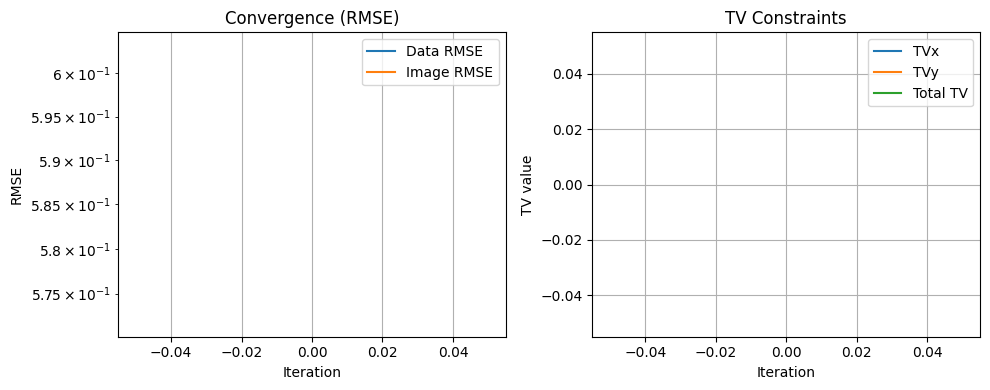

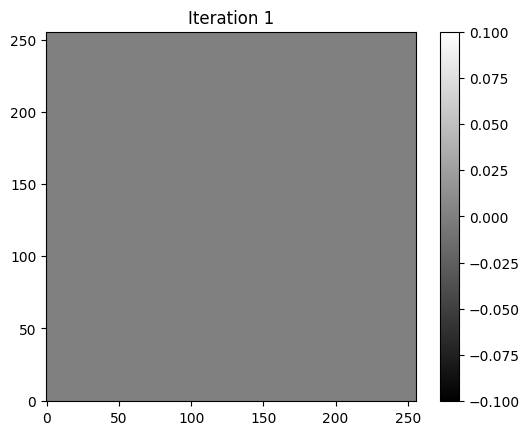

Iter: 2 TVX: 552.0133414401571 : 1462.1581360343844  TVY: 1228.204977419939 : 1424.7765859607607  TV: 1488.7694312573692 : 2365.855936721384
derr (combined): 0.20882279292939562  ierr: 0.32358625119273265


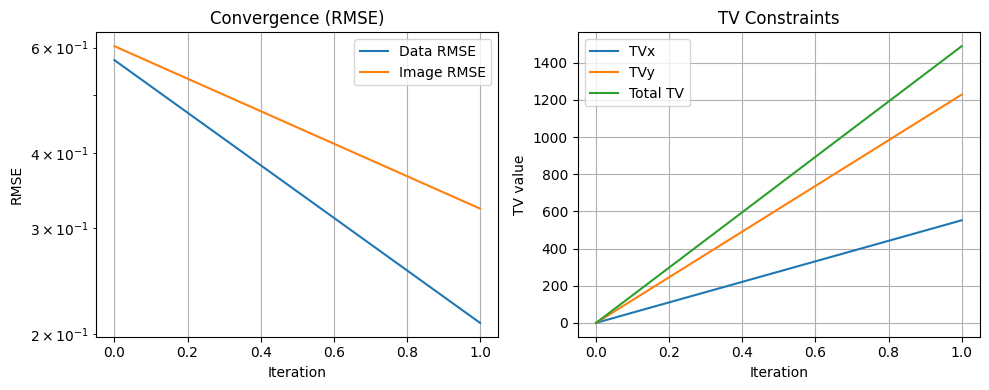

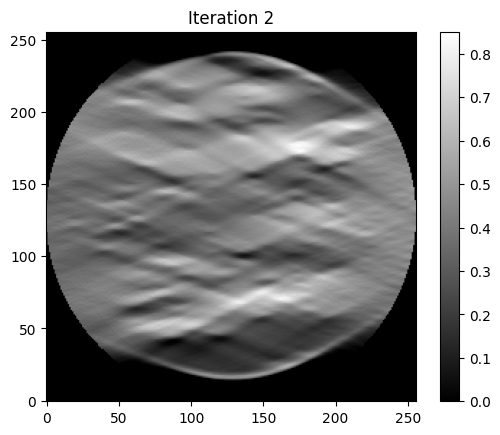

Iter: 5 TVX: 1433.7181182506288 : 1462.1581360343844  TVY: 2761.6950023021445 : 1424.7765859607607  TV: 3478.0232345516997 : 2365.855936721384
derr (combined): 0.43102935529048336  ierr: 0.480500370588608


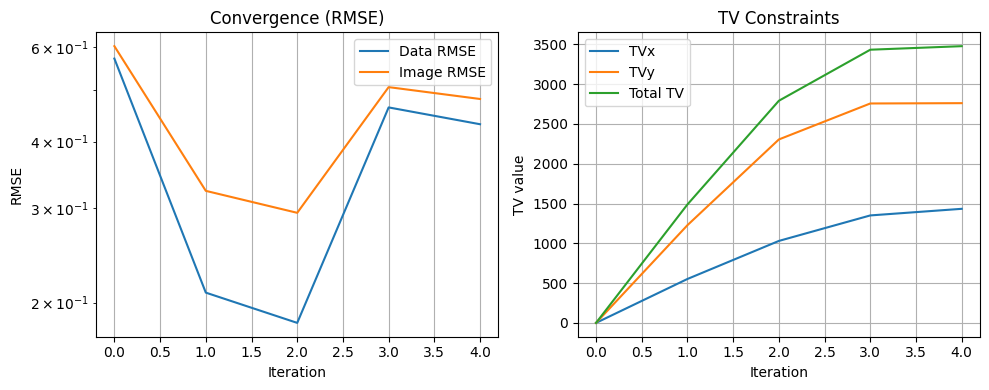

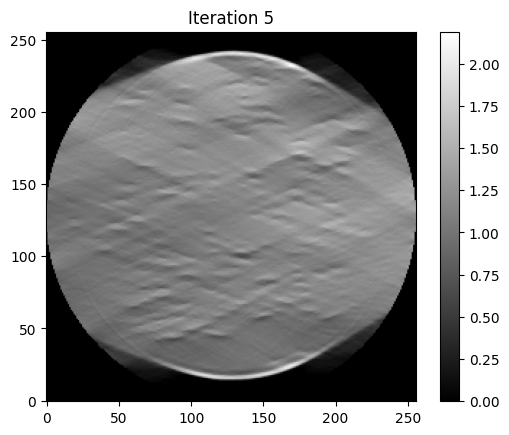

Iter: 10 TVX: 1609.1317385069171 : 1462.1581360343844  TVY: 2436.839819769379 : 1424.7765859607607  TV: 3241.985268973829 : 2365.855936721384
derr (combined): 0.18022658360918914  ierr: 0.2794942766986949


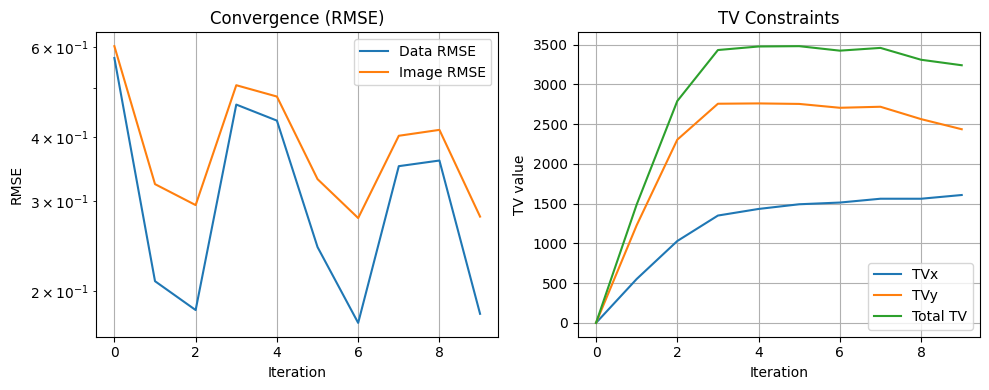

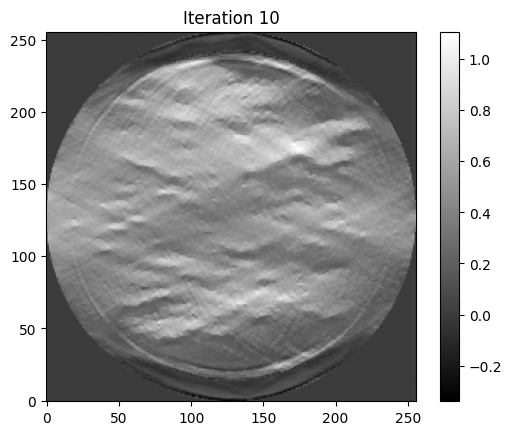

Iter: 20 TVX: 2321.378523052926 : 1462.1581360343844  TVY: 2867.0575679920285 : 1424.7765859607607  TV: 4161.645306565491 : 2365.855936721384
derr (combined): 0.17718180375798478  ierr: 0.23604424712405617


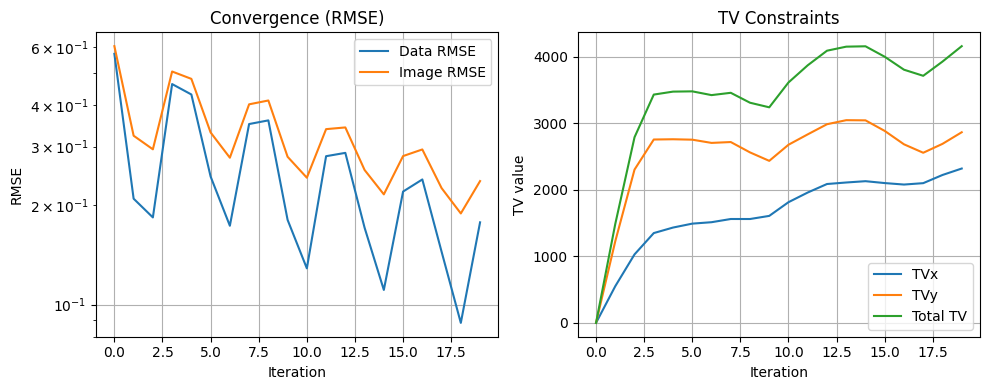

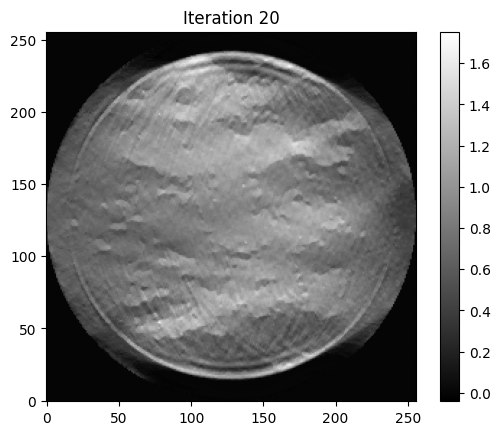

Iter: 50 TVX: 1891.1696003688678 : 1462.1581360343844  TVY: 2011.5600020634142 : 1424.7765859607607  TV: 3148.226214503288 : 2365.855936721384
derr (combined): 0.040377765684129714  ierr: 0.18298524278396613


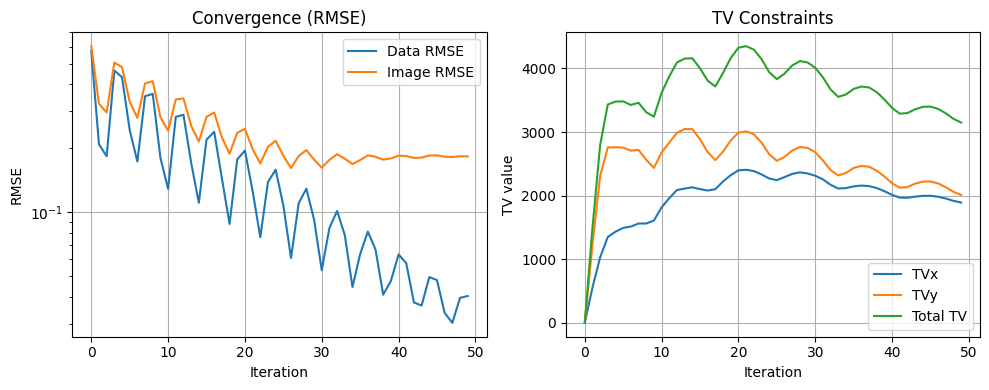

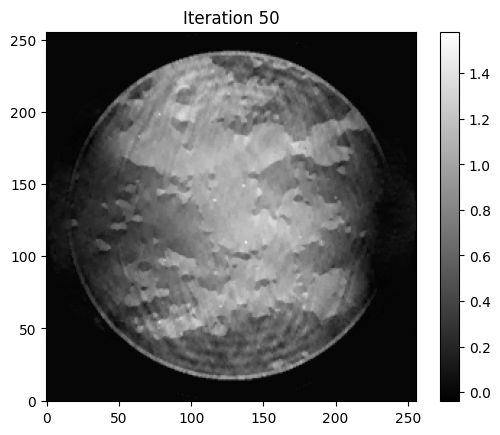

Iter: 100 TVX: 1821.08487030785 : 1462.1581360343844  TVY: 1753.7399128448365 : 1424.7765859607607  TV: 2940.0244714941177 : 2365.855936721384
derr (combined): 0.007795661616630929  ierr: 0.15596396333131046


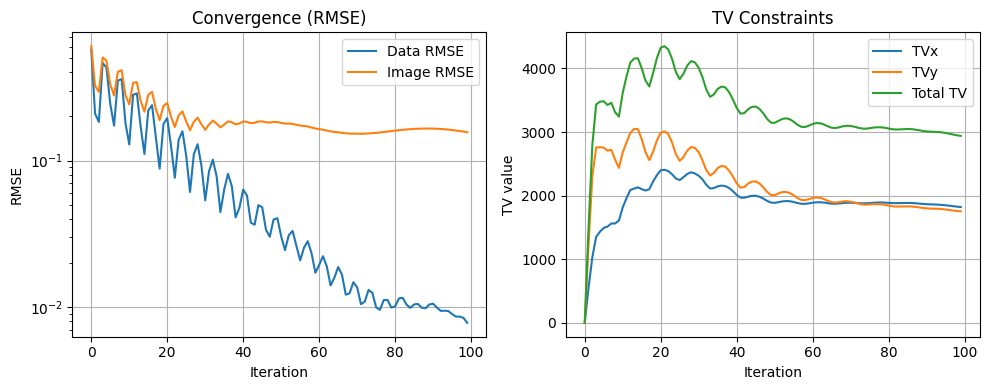

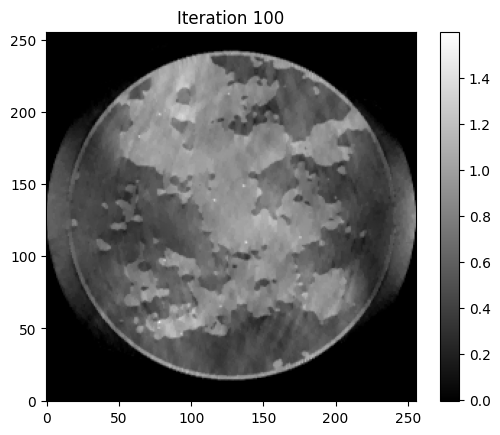

Iter: 200 TVX: 1528.4082692401505 : 1462.1581360343844  TVY: 1551.4941142119337 : 1424.7765859607607  TV: 2543.432027274731 : 2365.855936721384
derr (combined): 0.002557939201876168  ierr: 0.11643214438032645


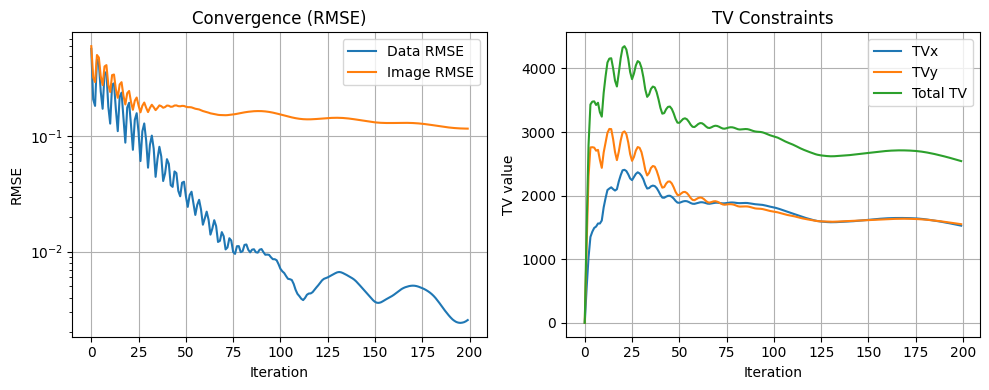

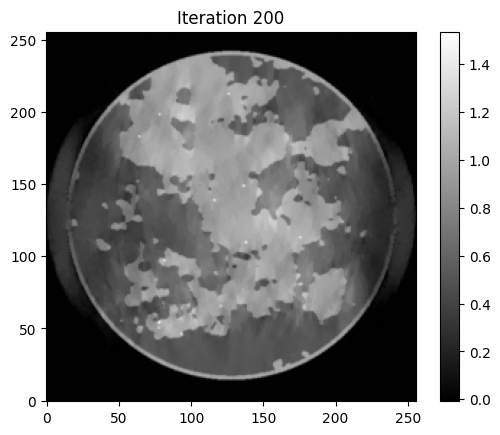

Iter: 300 TVX: 1406.547632012701 : 1462.1581360343844  TVY: 1455.3771861225434 : 1424.7765859607607  TV: 2374.5112285088144 : 2365.855936721384
derr (combined): 0.002097205943592446  ierr: 0.0968342634441747


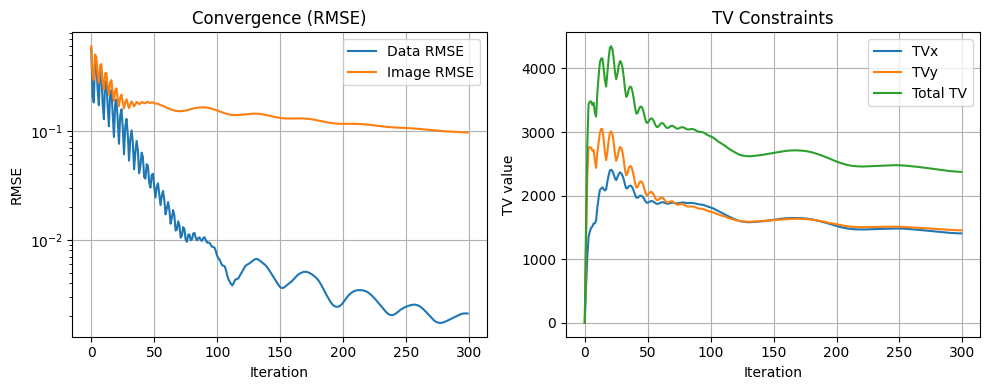

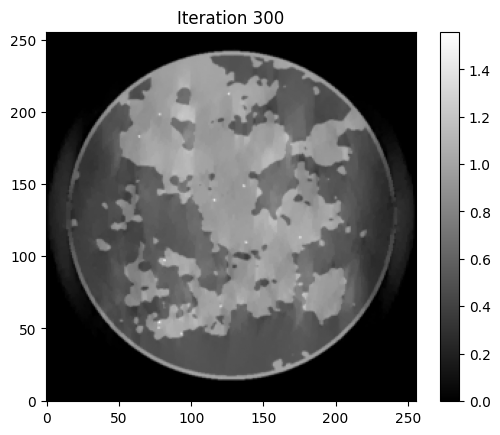

Iter: 400 TVX: 1368.9925660139088 : 1462.1581360343844  TVY: 1423.900187201015 : 1424.7765859607607  TV: 2319.7948647314524 : 2365.855936721384
derr (combined): 0.0015990926025183459  ierr: 0.0821181359080922


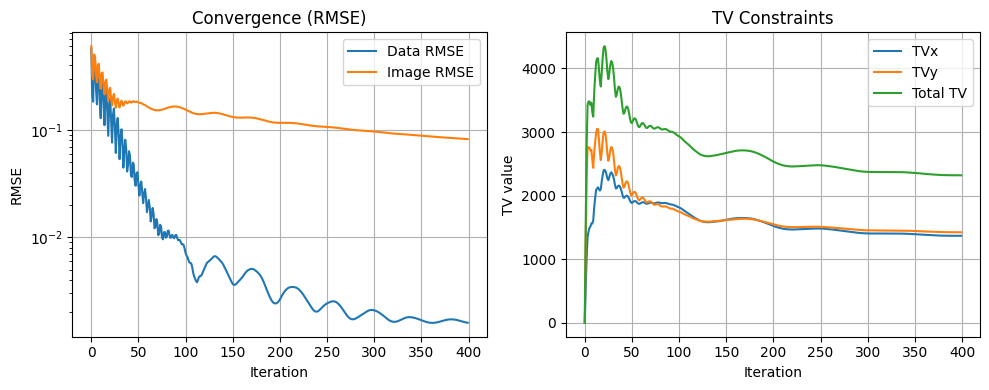

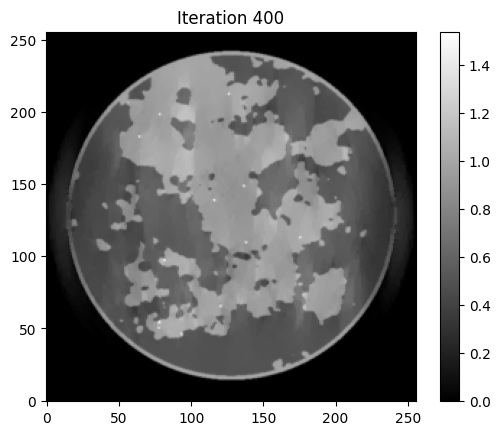

Iter: 500 TVX: 1346.1009976014088 : 1462.1581360343844  TVY: 1406.0799802479053 : 1424.7765859607607  TV: 2286.6930671280547 : 2365.855936721384
derr (combined): 0.0015931050017478406  ierr: 0.07276125326083054


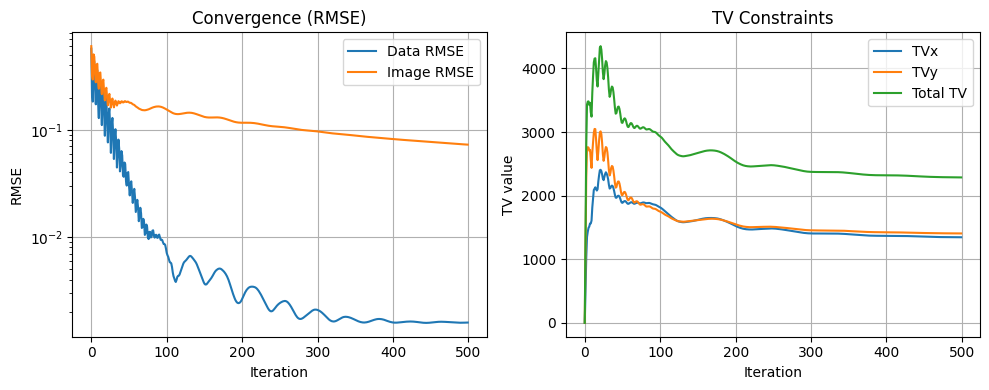

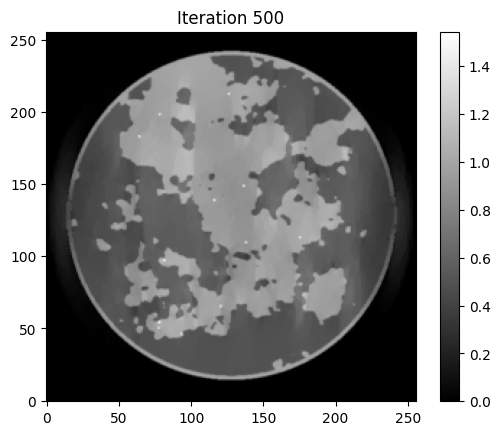

Iter: 600 TVX: 1330.9325028406722 : 1462.1581360343844  TVY: 1395.4877419117668 : 1424.7765859607607  TV: 2264.347885136392 : 2365.855936721384
derr (combined): 0.0015902292789534654  ierr: 0.06589981807262052


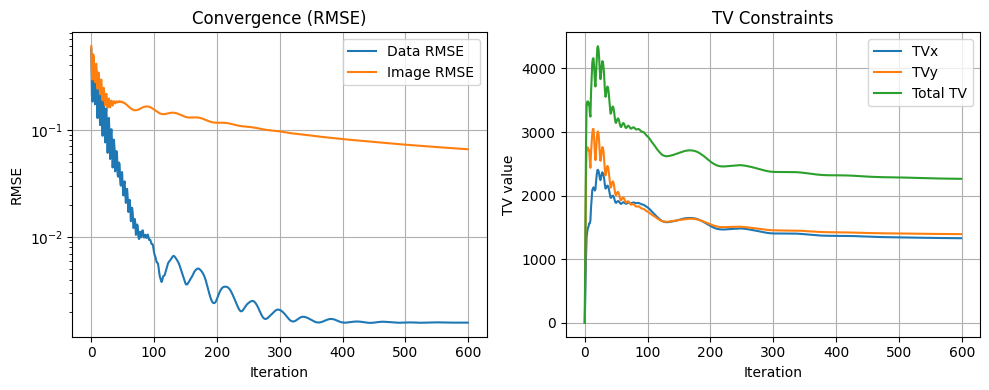

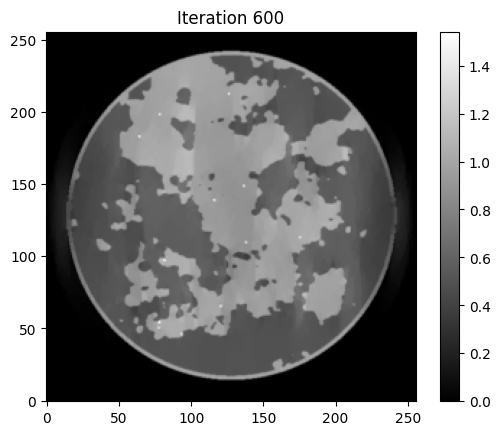

Iter: 700 TVX: 1320.9458906341115 : 1462.1581360343844  TVY: 1388.9128197504504 : 1424.7765859607607  TV: 2249.3368573751677 : 2365.855936721384
derr (combined): 0.0015942283821116978  ierr: 0.0605133775871116


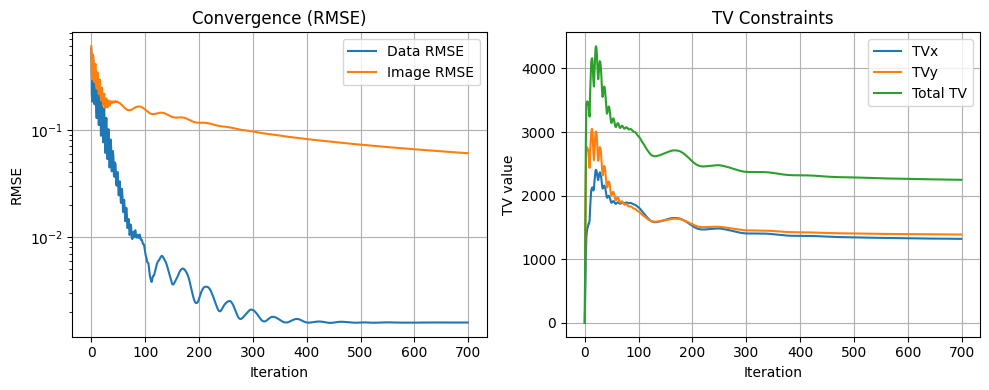

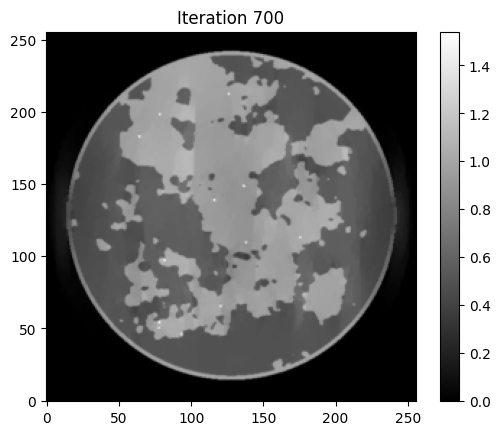

Iter: 800 TVX: 1314.0583133863488 : 1462.1581360343844  TVY: 1384.7830325249606 : 1424.7765859607607  TV: 2238.8776554247434 : 2365.855936721384
derr (combined): 0.0015962301488193012  ierr: 0.056055163505738886


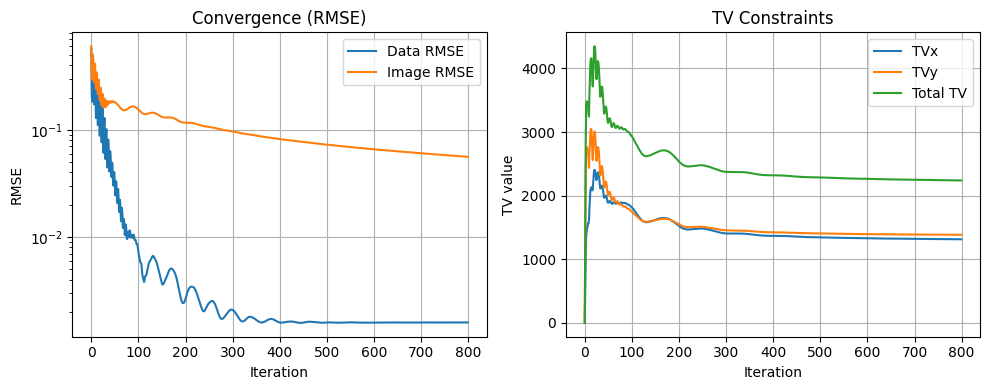

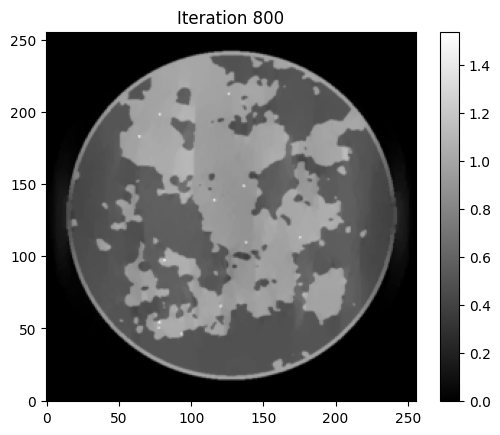

Iter: 900 TVX: 1309.0614023824548 : 1462.1581360343844  TVY: 1381.9842485962176 : 1424.7765859607607  TV: 2231.083991815228 : 2365.855936721384
derr (combined): 0.0015969456525698309  ierr: 0.05223156133771656


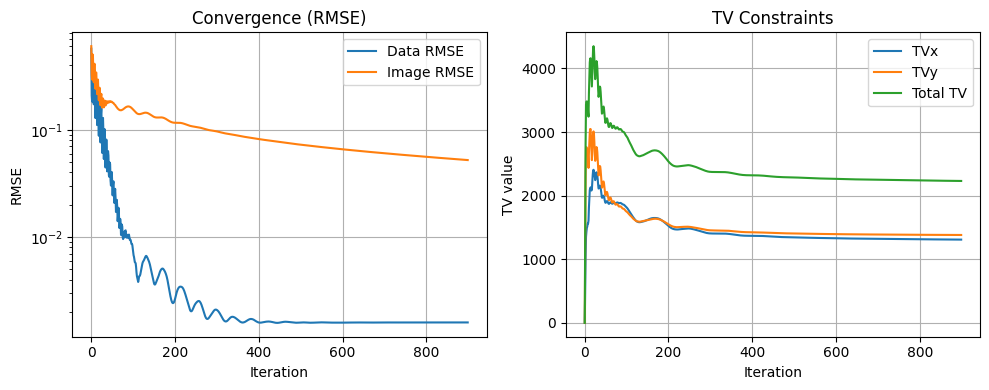

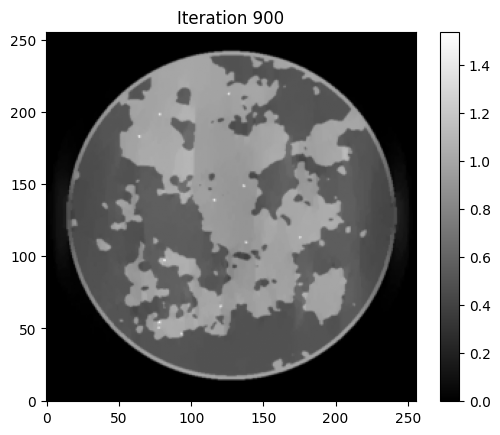

Iter: 1000 TVX: 1304.8712382916483 : 1462.1581360343844  TVY: 1380.0021579733052 : 1424.7765859607607  TV: 2224.823516898203 : 2365.855936721384
derr (combined): 0.0015974865717645458  ierr: 0.04891240168602158


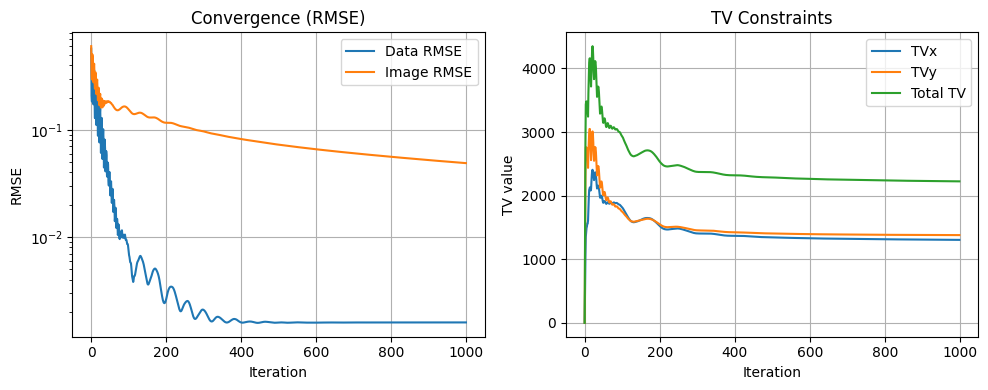

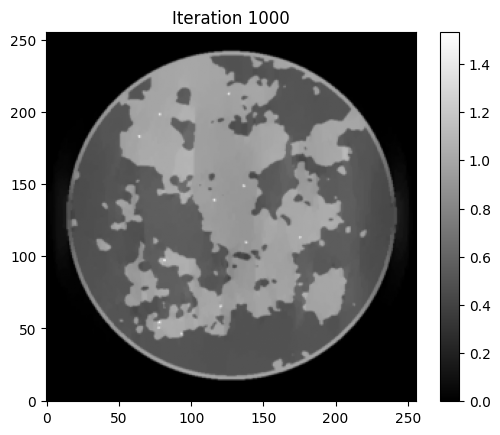

Iter: 1200 TVX: 1298.8670714982627 : 1462.1581360343844  TVY: 1377.283631946749 : 1424.7765859607607  TV: 2215.7833694569454 : 2365.855936721384
derr (combined): 0.0015983569295899309  ierr: 0.04347986540786398


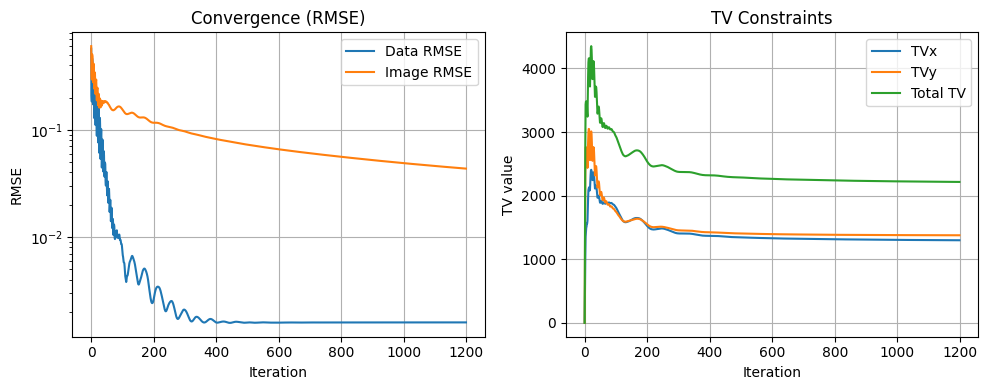

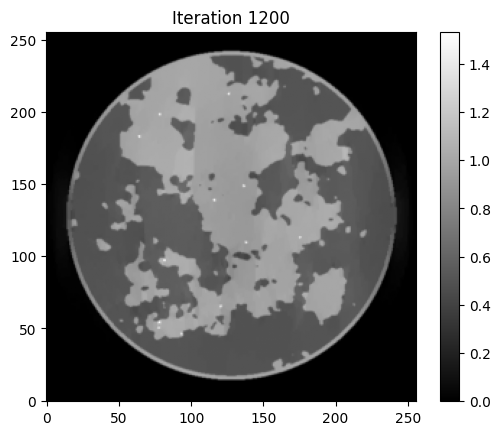

Iter: 1400 TVX: 1295.124166853582 : 1462.1581360343844  TVY: 1375.6208098165 : 1424.7765859607607  TV: 2210.096647029926 : 2365.855936721384
derr (combined): 0.0015989791180936214  ierr: 0.03937546152029999


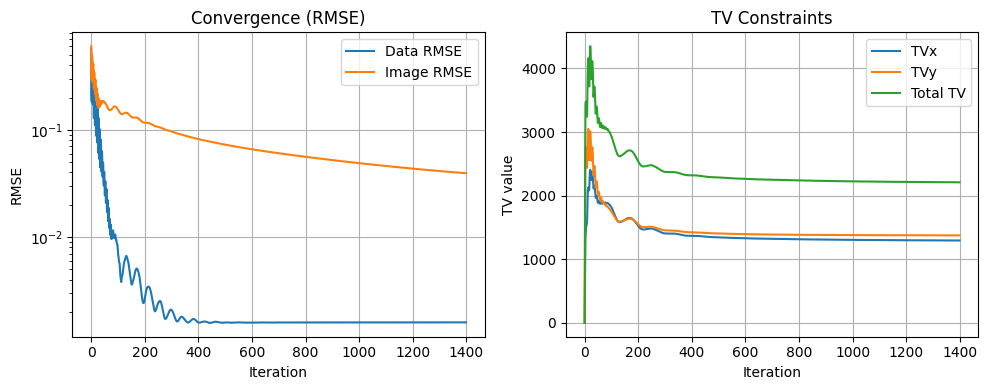

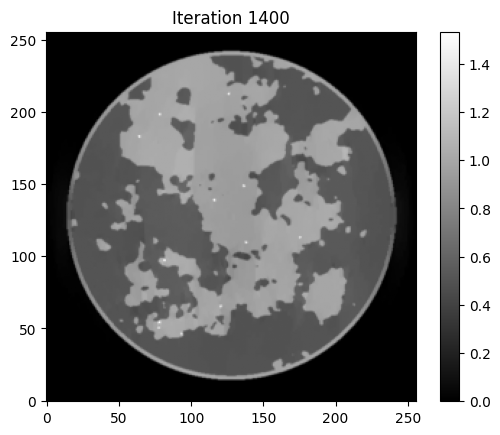

Iter: 1600 TVX: 1293.5138771552645 : 1462.1581360343844  TVY: 1374.512906839047 : 1424.7765859607607  TV: 2207.100786484738 : 2365.855936721384
derr (combined): 0.001599409822854276  ierr: 0.03640003096540124


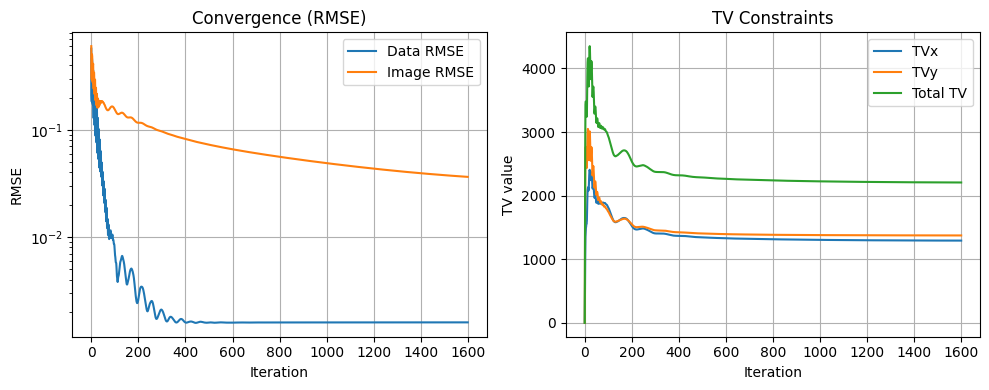

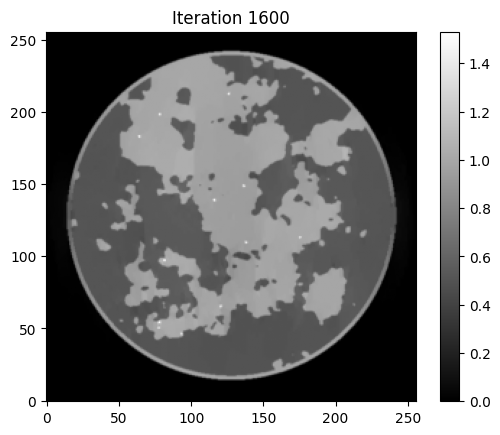

Iter: 1800 TVX: 1292.8652837647844 : 1462.1581360343844  TVY: 1373.7787388922548 : 1424.7765859607607  TV: 2205.567294834806 : 2365.855936721384
derr (combined): 0.0015997971614497403  ierr: 0.03431772529309691


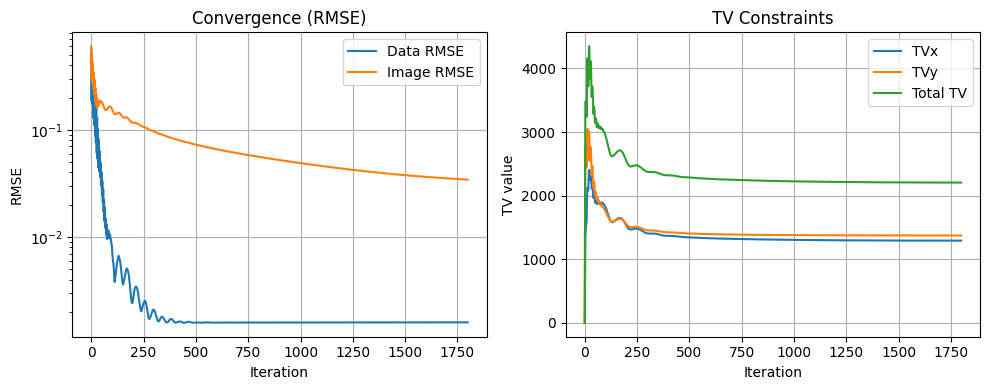

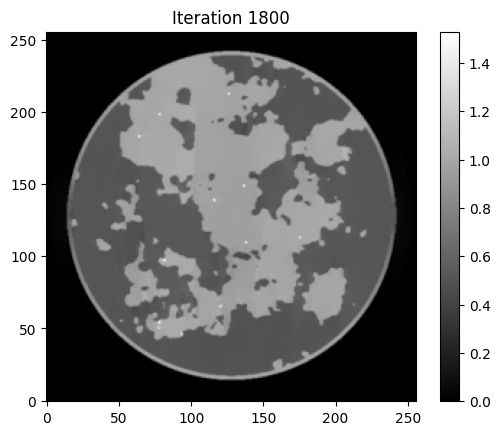

Iter: 2000 TVX: 1292.856711115009 : 1462.1581360343844  TVY: 1373.2604052326474 : 1424.7765859607607  TV: 2204.971725712703 : 2365.855936721384
derr (combined): 0.0016002209773368094  ierr: 0.03292781191447615


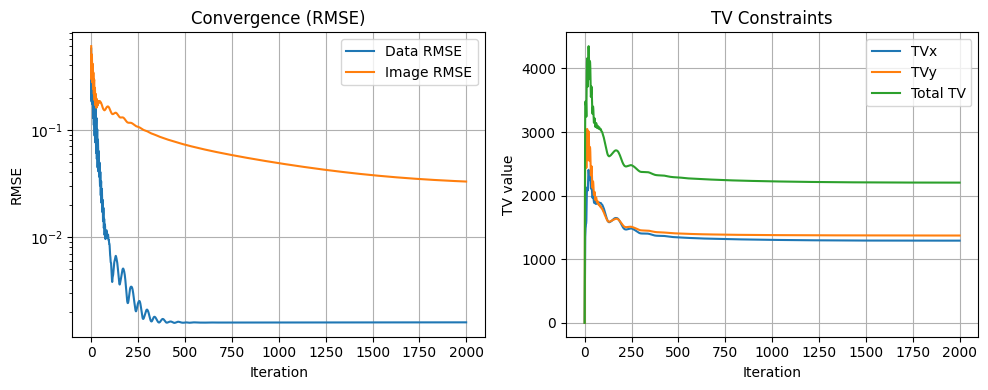

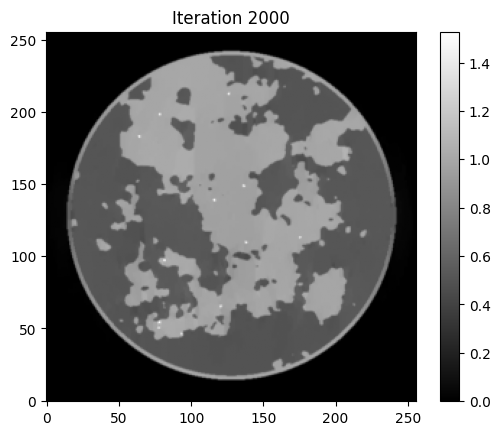

In [26]:

#totalvec = xim*1.
#input("hi")

theta = 1.0
itermax = 2000
itr = 0

# Allocate vars
xim.fill(0.)
yim = xim*0.
xbarim = xim*0.
wimp = xim*0.

ysino = zeros([nviews,nbins])        # legacy
ysino_hi = zeros([nviews,nbins])     # high-pass dual
ysino_lo = zeros([nviews,nbins])     # low-pass dual
ygradx = xim*0.
ygrady = xim*0.

derrs = []; ierrs = []; tvxs = []; tvys = []; tvs = []
istops = [1,2,5,10,20,50,100,200,300,400,500,600,700,800,900,1000,1200,1400,1600,1800,2000,3000,4000,5000]

while itr < itermax:
    itr += 1

    # Save old
    ysinoold = ysino*1.          # legacy
    ysinoold_hi = ysino_hi*1.
    ysinoold_lo = ysino_lo*1.
    ygradxold = ygradx*1.
    ygradyold = ygrady*1.
    yimold = yim*1.

    # ---- PRIMAL UPDATE ----
    wimp.fill(0.)

    if two_channel:
        worksino = zeros([nviews,nbins])
        circularFanbeamProjection(xbarim, worksino)

        # adjoint of channels
        # NB: R_hi/lo are symmetric in this Fourier weighting setup
        Axb_hi = R_hi(worksino); Axb_lo = R_lo(worksino)

        imtmp = zeros_like(xim)
        circularFanbeamBackProjection(R_hi(ysino_hi), imtmp); wimp += imtmp
        imtmp.fill(0.)
        circularFanbeamBackProjection(R_lo(ysino_lo), imtmp); wimp += imtmp
        wimp *= nusino
    else:
        worksino = zeros([nviews,nbins])
        circularFanbeamProjection(xbarim, worksino)
        Axb = fo(worksino)
        circularFanbeamBackProjection(Axb, wimp)
        wimp *= nusino

    wimp *= mask

    wimqx = mdivx(ygradx); wimqx *= nuxgrad; wimqx *= mask
    wimqy = mdivy(ygrady); wimqy *= nuygrad; wimqy *= mask
    wiml1 = l1f*yim

    ximold = xim*1.
    xim = xim - tau*(wimp + wimqx + wimqy + wiml1)
    xim[xim<0.0] = 0.  # nonnegativity
    xbarim = xim + theta*(xim - ximold)

    # ---- DUAL UPDATES ----
    worksino = zeros([nviews,nbins])
    circularFanbeamProjection(xbarim, worksino)

    if two_channel:
        Ax_hi = R_hi(worksino);  Ax_lo = R_lo(worksino)
        Ax_hi *= nusino;         Ax_lo *= nusino

        resid_hi = Ax_hi - sinodata_hi_sc
        resid_lo = Ax_lo - sinodata_lo_sc

        derr = sqrt( ((resid_hi/nusino)**2).sum() + ((resid_lo/nusino)**2).sum() )/sqrt(1.*nviews*nbins)
        derrs.append(derr)

        ysino_hi = ysino_hi + sig_hi*resid_hi
        ymag_hi = sqrt( (ysino_hi**2).sum() )
        if ymag_hi - sig_hi*nusino*epssc_hi > 0:
            ysino_hi *= (ymag_hi - sig_hi*nusino*epssc_hi)/ymag_hi
        else:
            ysino_hi *= 0.0

        ysino_lo = ysino_lo + sig_lo*resid_lo
        ymag_lo = sqrt( (ysino_lo**2).sum() )
        if ymag_lo - sig_lo*nusino*epssc_lo > 0:
            ysino_lo *= (ymag_lo - sig_lo*nusino*epssc_lo)/ymag_lo
        else:
            ysino_lo *= 0.0
    else:
        Ax = fo(worksino); Ax *= nusino
        resid = Ax - sinodatasc
        wdist = sqrt((resid**2).sum())
        wdistn = (wdist/nusino)/sqrt(1.*nviews*nbins)
        derrs.append(wdistn)
        ysino = (ysino + sig*resid)
        ymag = sqrt( (ysino**2).sum() )
        if ymag - sig*nusino*epssc > 0:
            ysino *= (ymag - sig*nusino*epssc)/ymag
        else:
            ysino *= 0.

    # DTV x-block
    tgx = gradx(xbarim); tgx *= nuxgrad
    tvc = sqrt((tgx**2)).sum()/nuxgrad; tvxs.append(tvc)
    ptilx = ygradx + sig*tgx
    ptilmag = maximum(sqrt(ptilx**2), (2.-alpha))
    ygradx = (2.-alpha)*ptilx/ptilmag

    # DTV y-block
    tgy = grady(xbarim); tgy *= nuygrad
    tvc = sqrt((tgy**2)).sum()/nuygrad; tvys.append(tvc)
    ptily = ygrady + sig*tgy
    ptilmag = maximum(sqrt(ptily**2), (alpha))
    ygrady = alpha*ptily/ptilmag

    # L1(f) block
    tl1 = l1f*xbarim
    ptil1 = yim + sig*tl1
    ptilmag = maximum(sqrt(ptil1**2), (beta))
    yim = beta*ptil1/maximum(ptilmag,1.e-10)

    # TV for logging
    tgx_log,tgy_log = gradim(xbarim)
    tvc = sqrt((tgx_log**2 + tgy_log**2)).sum()
    tvs.append(tvc)

    # He–Yuan predictor–corrector (rho)
    ygradx = ygradxold - rho*(ygradxold - ygradx)
    ygrady = ygradyold - rho*(ygradyold - ygrady)
    yim     = yimold   - rho*(yimold   - yim)
    if two_channel:
        ysino_hi = ysinoold_hi - rho*(ysinoold_hi - ysino_hi)
        ysino_lo = ysinoold_lo - rho*(ysinoold_lo - ysino_lo)
    else:
        ysino = ysinoold - rho*(ysinoold - ysino)
    xim = ximold - rho*(ximold - xim)

    # diagnostics vs ground truth
    idist = sqrt( ((xbarim - phimage)**2).sum()/(nx*ny) )
    ierrs.append(idist)

    # existing plots/prints (as in your notebook)
    if itr in istops:
        if two_channel:
            print("Iter:", itr, "TVX:", tvxs[-1], ":", truetvx, " TVY:", tvys[-1], ":", truetvy, " TV:", tvs[-1], ":", truetv)
            print("derr (combined):", derrs[-1], " ierr:", ierrs[-1])
        else:
            print("Iter:", itr, "TVX:", tvxs[-1], ":", truetvx, " TVY:", tvys[-1], ":", truetvy, " TV:", tvs[-1], ":", truetv)
            print("derr:", derrs[-1], " ierr:", ierrs[-1])

        # Plot convergence curves (kept from your original)
        try:
            import matplotlib.pyplot as plt
            plt.figure(figsize=(10,4))
            plt.subplot(1,2,1)
            plt.plot(derrs, label="Data RMSE")
            plt.plot(ierrs, label="Image RMSE")
            plt.yscale('log')
            plt.xlabel("Iteration")
            plt.ylabel("RMSE")
            plt.legend()
            plt.grid()
            plt.title("Convergence (RMSE)")

            plt.subplot(1,2,2)
            plt.plot(tvxs, label="TVx")
            plt.plot(tvys, label="TVy")
            plt.plot(tvs, label="Total TV")
            plt.xlabel("Iteration")
            plt.ylabel("TV value")
            plt.legend()
            plt.grid()
            plt.title("TV Constraints")

            plt.tight_layout()
            plt.show()
        except Exception as e:
            print("Plotting error:", e)

        try:
            from matplotlib.pyplot import imshow, title, colorbar, draw, pause
            imshow(xbarim.T, cmap='gray', origin='lower')
            title(f"Iteration {itr}")
            colorbar(); draw(); pause(0.01)
        except Exception as e:
            print("Display error:", e)
